In [8]:
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [4]:
path = 'cat_emails_v2(in).csv'

with open(path, 'r', encoding="utf-8", errors="replace") as f:
    raw_lines = f.readlines()

records = []
in_record = False
current_category = None
email_parts = []

for line in raw_lines[1:]:

    if not in_record:
        if not line.strip():
            continue

        if line.lstrip().startswith('"'):
            in_record = True
            email_parts = []

            l = line.strip()
            if l.startswith('"'):
                l = l[1:]

            idx = l.find(',')
            if idx == -1:

                in_record = False
                current_category = None
                email_parts = []
                continue

            current_category = l[:idx].strip()

            rest = l[idx+1:]
            email_parts.append(rest)

    else:
        email_parts.append(line)

        if line.strip().endswith('"""'):

            full_text = "".join(email_parts)

            full_text_clean = (
                full_text.replace('"""', '')
                         .replace('""', '"')
                         .replace('"', '')
                         .strip()
            )

            records.append((current_category, full_text_clean))

            in_record = False
            current_category = None
            email_parts = []


data = pd.DataFrame(records, columns = ['category', 'email_text'])

data.to_csv('clean_emails.csv', index = False)

print('Parsed emails: ', len(data))

Parsed emails:  5000


In [5]:
data

,category,email_text
0,Financing balance credit,"Re: meines – Klärung notwendig,Hallo,\nkönnen ..."
1,Third party purchase,"Re: rechnung – Klärung notwendig,Sehr geehrtes..."
2,Account clarification,"Re: Mehrere Anliegen (betrag, um, arag),Sehr g..."
3,Follow-up Contract,"Re: Mehrere Anliegen (würde, https, pro),Re: O..."
4,Devinculation,"Dringend: Bitte um Rückmeldung zu 06 03,Hallo,..."
...,...,...
4995,Contract adjustment,"Beschwerde wegen anpassung,Sehr geehrte Damen ..."
4996,Calculations,"Re: Mehrere Anliegen (danke für, überwiesen, d..."
4997,Fuel card/maintenance,"Vertrag VNR-622212 – Frage zu gmbh,Sehr geehrt..."
4998,Policy/endorsement/cover,"Unterlagen polizzenkopie noch nicht erhalten,G..."


In [7]:
len(data['category'].value_counts())

34

In [9]:
data['label'] = data['category'].astype('category').cat.codes

train_data, test_data = train_test_split(data, test_size = 500, random_state = 42, stratify = data['label'])
train_dataset = Dataset.from_pandas(train_data)
test_dataset  = Dataset.from_pandas(test_data)

model_name = 'distilbert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['email_text'], truncation = True, padding = 'max_length', max_length = 256)

train_dataset = train_dataset.map(tokenize, batched = True)
test_dataset = test_dataset.map(tokenize, batched = True)

train_dataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = data['label'].nunique())

device = torch.device('cuda')
model.to(device)

args = TrainingArguments(
    output_dir = 'base_email_model',
    learning_rate = 2e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 10,
    weight_decay = 0.01,
    logging_steps = 50,
    save_strategy = 'epoch',
    eval_strategy = 'epoch',
    load_best_model_at_end = True,
    report_to = 'none'
)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
)

trainer.train()
trainer.save_model('base_email_classifier')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,2.637700,2.370829
2,1.107400,0.924338
3,0.531500,0.477535
4,0.287600,0.346232
5,0.284700,0.368428
6,0.216700,0.358349
7,0.208600,0.369422
8,0.161700,0.331038
9,0.166900,0.355155
10,0.143200,0.351074


In [10]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis = 1)
labels = predictions.label_ids

label_to_category = dict(enumerate(data['category'].astype('category').cat.categories))

print(classification_report(labels, preds, target_names = list(label_to_category.values())))

                                          precision    recall  f1-score   support

                   1st Level Onlinetools       0.88      1.00      0.93        14
                   Account clarification       1.00      0.77      0.87        13
                          Bank statement       0.68      0.79      0.73        19
                            Calculations       0.94      1.00      0.97        15
                               Call-back       0.93      1.00      0.96        13
                            Cancellation       0.84      0.94      0.89        17
                    Change customer data       0.85      0.94      0.89        18
          Change in payment transactions       0.90      1.00      0.95        19
                       Claims management       0.92      0.92      0.92        12
                    Compensation release       0.83      0.94      0.88        16
                               Complaint       0.92      0.86      0.89        14
               

In [13]:
test_texts = test_dataset.to_pandas()['email_text'].tolist()
test_true_labels = test_dataset.to_pandas()['label'].tolist()

errors = [ ]

for i, (true, pred) in enumerate(zip(test_true_labels, preds)):
    if true != pred:
        errors.append({'true': label_to_category[true], 'pred': label_to_category[pred]})

errors_data = pd.DataFrame(errors)

print('Sample of model mistakes (top 20)')
print(errors_data.head(20))

Sample of model mistakes (top 20)
                                        true                            pred
0                         Contract rewriting           Fuel card/maintenance
1                      Account clarification  Change in payment transactions
2                               Cancellation                 Insurance offer
3               General contract information                  Bank statement
4                   Policy/endorsement/cover        Financing balance credit
5                                  Complaint           1st Level Onlinetools
6                            Insurance offer                Insurance change
7                               Data extract            Change customer data
8                   Financing balance credit              Follow-up Contract
9                       Change customer data                    Data extract
10                     Account clarification  Change in payment transactions
11  Financing balance residual value leasi

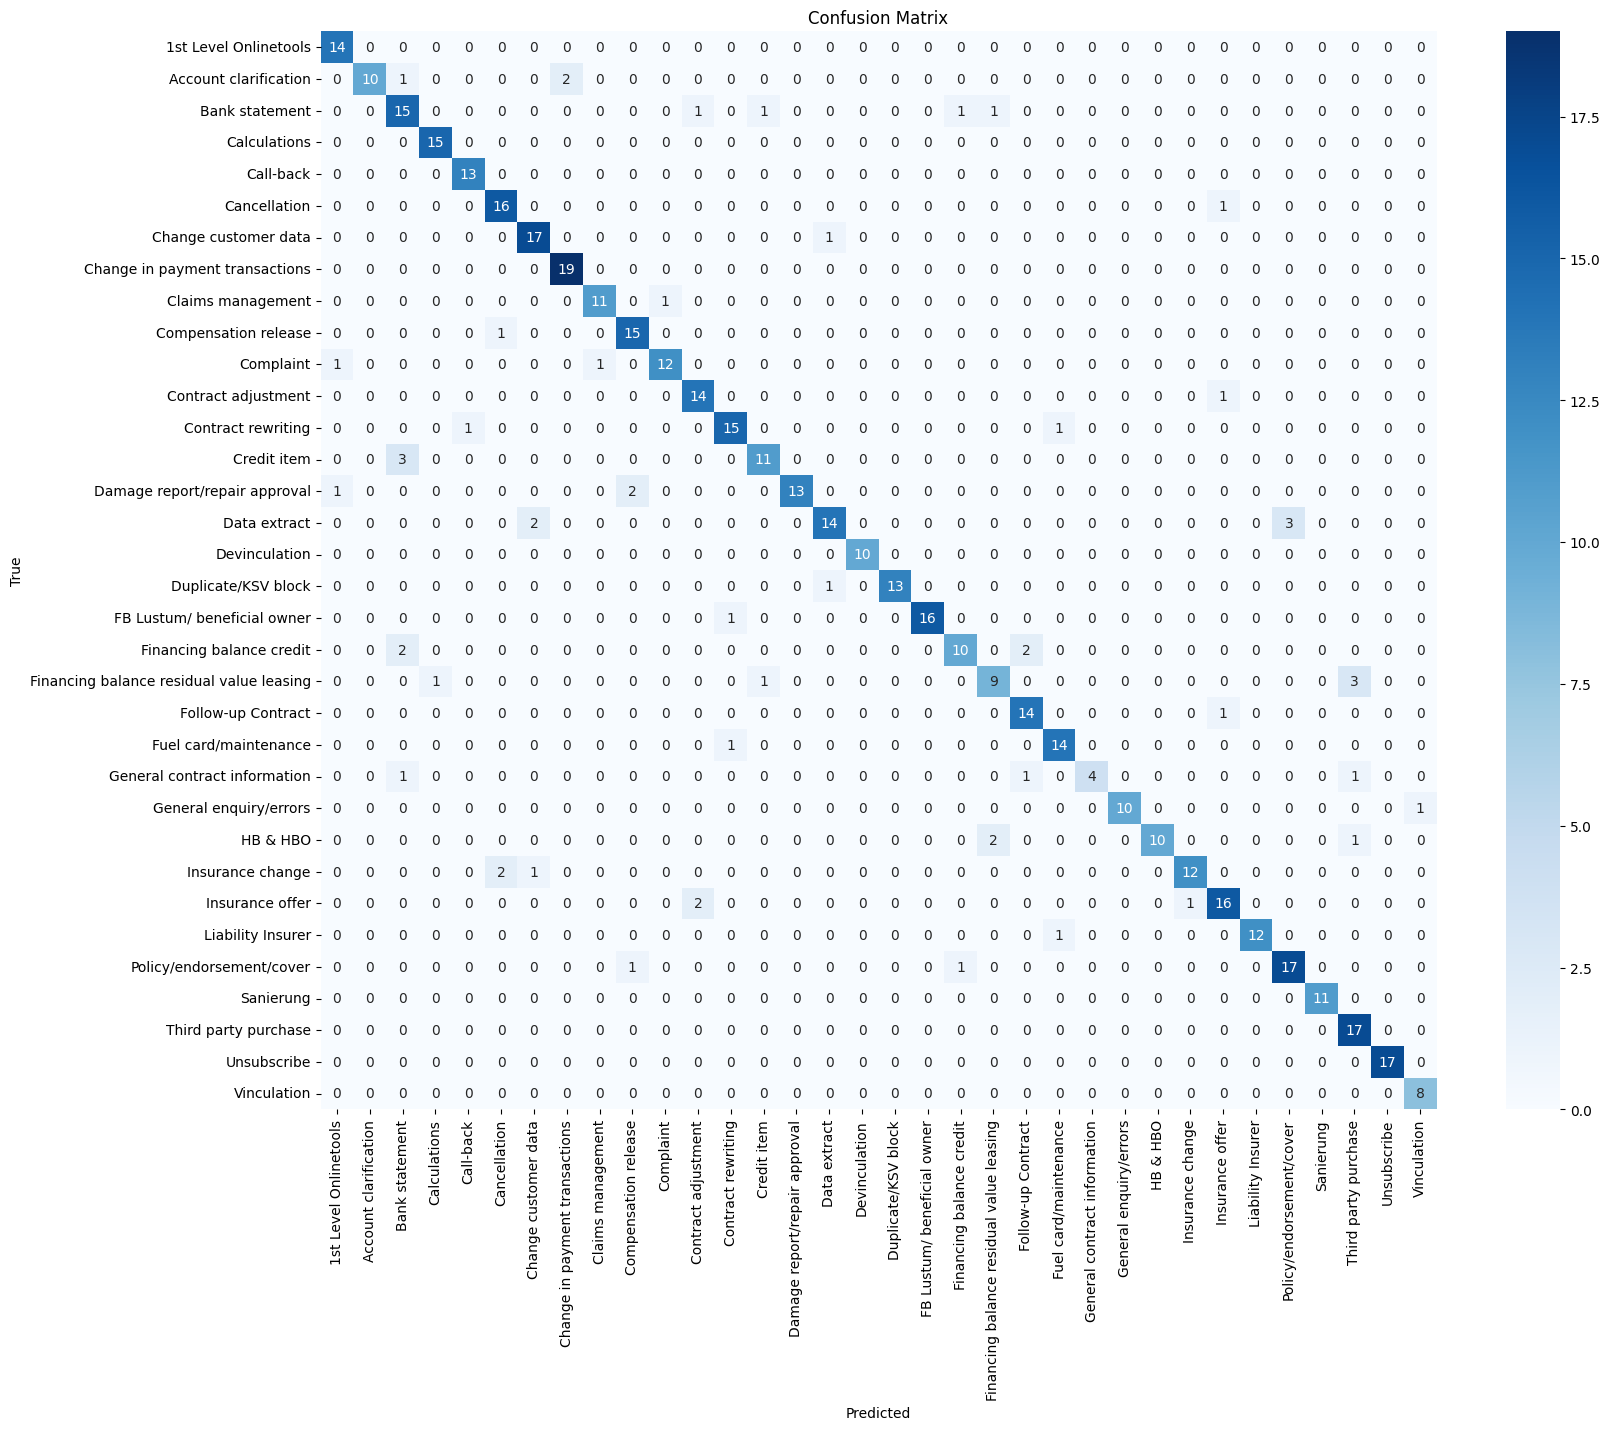

In [14]:
plt.figure(figsize = (18, 14))
sns.heatmap(confusion_matrix(labels, preds), annot = True, cmap = 'Blues', xticklabels = label_to_category.values(), yticklabels = label_to_category.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()